# Monte Carlo Lattice QCD

In [1]:
using Plots

In [1]:
function uniform(low, high, size=1)
    h = high - low
    return h * rand(size) .+ low
end

uniform (generic function with 2 methods)

In [20]:
x = zeros(20)
ε = 1.4
a = 0.5
N = length(x)
ζ = uniform(-ε, ε, N)
η = uniform(0, 1, N)
new_x = x + ζ

20-element Vector{Float64}:
 -0.07177985630050987
  1.3532111221167424
  0.6932785158609542
 -0.269765034698787
 -1.090037153987779
  1.36169646168627
 -0.37435683798806085
 -1.3879099396547279
  0.5591912869657387
 -1.276711415768407
 -1.189121645849331
  1.0264941027725607
  0.996612418916536
 -0.09474293631814001
  0.6786481146877446
 -0.8619716711841485
  0.6276156826878001
 -0.4960943783722983
  0.4174183064053736
 -1.3186526135870307

In [22]:
function dS(old_x, new_x, a, j)
    site_left = mod1(j-1, N)
    site_right = mod1(j+1, N)
    return (a/2) * new_x[j]^2 + (new_x[j] / a) * (new_x[j] - old_x[site_left] - old_x[site_right])
end

dS (generic function with 2 methods)

In [42]:
dS(x, new_x, a, 20)

3.9124006094697905

## Metropolis update algorithm
- Generate a random number $\zeta$, with probability uniformly distributed between $-\varepsilon$ and $\varepsilon$ for some constant $\varepsilon$.
- Replace $x_j \rightarrow x_j + \zeta$ and compute the change $\Delta S$ in the action caused by this replacement (generally only a few terms in the lattice action involve $x_j$, since lagrangians are local. Only these need be examined).
- If $\Delta S < 0$ (the action is reduced) retain the new value for $x_j$, and proceed to the next site
- If $\Delta S > 0$ generate a random number $\eta$ unformly distributed between 0 and 1. Retain the new value for $x_j$ if $\exp(−\Delta S)> \eta$, otherwise restore the old value. Proceed to the next site.

In [3]:
function metropolis_update!(x, S, a, ε)
    N = length(x)
    ζ = uniform(-ε, ε, N) # Random amount to potentially alter each site
    η = uniform(0, 1, N) # Random value based on density of sampling distribution
    
#     for site in 1:N
#         old_x = x[site]
#         old_S = S(x, site, a)
#         x[site] += uniform(-ε, ε)
#         dS = S(x, site, a) - old_S
#         if (dS > 0) && exp(-dS) < uniform(0,1)
#             x[site] = old_x
#         end
#     end
end

metropolis_update! (generic function with 1 method)

In [4]:
function harmonic_oscillator_action(x, site, a)
    N = length(x)
    site_left = mod1(site - 1, N)
    site_right = mod1(site + 1, N)
    return (a/2) * x[site]^2 + (x[site] / a) * (x[site] - x[site_left] - x[site_right])
end

harmonic_oscillator_action (generic function with 1 method)

In [5]:
function compute_G(x::Vector{Float64}, n::Int64)
    N = length(x)
    # g = 0
    # for j in 1:N
    #     g = g + x[j] * x[mod1(j+n, N)]
    # end
    g = sum(x[j] * x[mod1(j+n, N)] for j in 1:N)
    return g/N
end

compute_G (generic function with 1 method)

## Monte Carlo approximation algorithm for a function $\Gamma[x]$ of a path $x$

- Initialize the path, for example, by setting all $x_j$s to zero.
- Update the path $5*N_{cor}$ to $10*N_{cor}$ times to thermalize it.
- Update the path $N_{cor}$ times, then compute $\Gamma[x]$ and save it. Repeat $N_{cf}$ times.
- Average the $N_{cf}$ values of $\Gamma[x]$ saved in the previous step to obtain a Monte Carlo estimate $\overline{\Gamma}$ for $\langle\langle \Gamma[x] \rangle\rangle$.

In [43]:
function monte_carlo_average(x::Vector{Float64}, G, N_cor, ε, N_cf, S)
    N = length(x)
    x = zeros(N)
    for j in 1:5*N_cor
        metropolis_update!(x, S, a, ε)
    end
    for α in 1:N_cf
        for j in 1:N_cor
            metropolis_update!(x, S, a, ε)
        end
        for n in 1:N
            G[α, n] = compute_G(x, n)
        end
    end
    avg_G = sum(G, dims=1) / N_cf
    return avg_G
end

monte_carlo_average (generic function with 2 methods)

In [47]:
N = 100;
N_cf = 100;
N_cor = 1000;
ε = 1.4;
a = 0.1;

In [48]:
x = zeros(20);
G = zeros(N_cf, N);

In [19]:
metropolis_update!(x, harmonic_oscillator_action, a, ε)

In [49]:
avg_G1, avg_G2 = monte_carlo_average(x, G, N_cor, ε, N_cf, harmonic_oscillator_action)

1×100 Matrix{Float64}:
 0.789548  0.746443  0.709449  0.677467  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

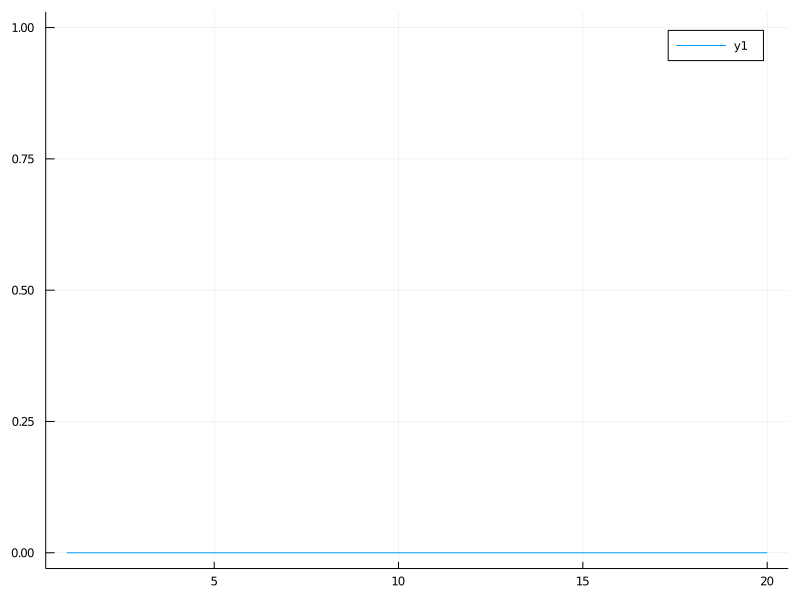

In [50]:
plot(1:20, x, size=(800, 600), html_output_format=:png)